In [1]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
import pandas as pd
np.random.seed(1)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import matplotlib

import dice_ml
from dice_ml.utils import helpers


%matplotlib inline



In [2]:
iris = sklearn.datasets.load_iris()

print(type(iris))

<class 'sklearn.utils._bunch.Bunch'>


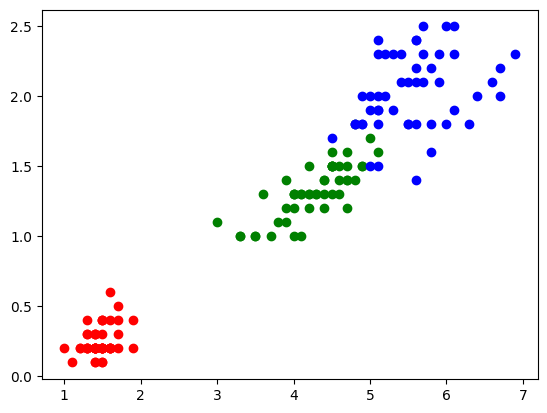

In [3]:
features = iris.data
labels = iris.target

plt.figure()
plt.scatter(features[labels == 0,2], features[labels == 0, 3], c = 'r', label = 'Setosa')
plt.scatter(features[labels == 1,2], features[labels == 1, 3], c = 'g', label = 'Versicolor')
plt.scatter(features[labels == 2,2], features[labels == 2, 3], c = 'b', label = 'Virginica')
plt.show()

# # Visualizing only classes green and blue in 3d (in the first three features)
# custom_colors = ['g', 'b']
# cmap_custom = matplotlib.colors.ListedColormap(custom_colors)
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(features[labels != 0,1], features[labels != 0,2], features[labels != 0,3], c = labels[labels != 0], cmap = cmap_custom)
# plt.show()

In [4]:
# Saving only the green and blue classes with features 2, and 3
features = iris.data
labels = iris.target

features = features[labels != 0] # Drop class 0
features = features[:,2:] # Drop features 0 and 1

labels = labels[labels != 0] # Drop class 0

# # Checking that the results look correct
# print(features.shape)
# print(labels.shape)
# custom_colors = ['g', 'b']
# cmap_custom = matplotlib.colors.ListedColormap(custom_colors)
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(features[:,0], features[:,1], features[:,2], c = labels, cmap = cmap_custom)
# plt.show()

In [5]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(features, labels, train_size=0.80)

print(train.shape)
print(test.shape)
print(labels_train.reshape(-1,1).shape)
print(labels_test.reshape(-1,1).shape)

train = torch.from_numpy(train)
test = torch.from_numpy(test)
labels_train = torch.from_numpy(labels_train).reshape(-1,1)
labels_test = torch.from_numpy(labels_test).reshape(-1,1)

print(train.shape)
print(test.shape)
print(labels_train.shape)
print(labels_test.shape)

labels_train = labels_train.remainder(2) # 'Relabels' class 2 as class 0 --> Now we have classes 0 and 1
labels_test = labels_test.remainder(2) # 'Relabels' class 2 as class 0 --> Now we have classes 0 and 1

print(labels_train[:5])
print(labels_test[:5])


(80, 2)
(20, 2)
(80, 1)
(20, 1)
torch.Size([80, 2])
torch.Size([20, 2])
torch.Size([80, 1])
torch.Size([20, 1])
tensor([[1],
        [0],
        [0],
        [0],
        [1]])
tensor([[0],
        [0],
        [1],
        [0],
        [0]])


In [7]:
print(test)
print(labels_test)

tensor([[6.1000, 1.9000],
        [5.6000, 1.4000],
        [5.1000, 1.6000],
        [6.4000, 2.0000],
        [5.9000, 2.3000],
        [4.1000, 1.0000],
        [4.7000, 1.5000],
        [5.6000, 2.2000],
        [5.0000, 1.5000],
        [5.3000, 2.3000],
        [5.1000, 1.9000],
        [4.0000, 1.3000],
        [4.5000, 1.7000],
        [5.9000, 2.1000],
        [5.1000, 1.9000],
        [3.9000, 1.2000],
        [3.7000, 1.0000],
        [4.2000, 1.3000],
        [5.6000, 2.1000],
        [3.5000, 1.0000]], dtype=torch.float64)


NameError: name 'test_labels' is not defined

In [6]:
# rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)

class LogisticRegressor(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
    def class_probabilities(self, x):
        with torch.no_grad():
            x = self.forward(x)
            class_probs = torch.cat((1-x, x), dim = 1)
        return class_probs.reshape(-1,2)
    
    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            predicted_class = x.detach().round()
        return predicted_class.reshape(-1,1)

model = LogisticRegressor(2,1)

In [7]:
# rf.fit(train, labels_train)

# Hyperparameters
lr = 0.05
num_epochs = 500

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

train = train.float()
test = test.float()
labels_train = labels_train.float()
labels_test = labels_test.float()

# Training loop
for epoch in range(num_epochs):
    
    model.train()
    optimizer.zero_grad()
    outputs = model.forward(train)
    loss = loss_fn(outputs, labels_train)
    loss.backward()
    optimizer.step()
    
    # Calculate training and validation accuracy every epoch
    training_accuracy = 0
    test_accuracy = 0
     
    model.eval()
    outputs = model.predict(train)
    training_accuracy = (outputs == labels_train).float().mean()
    outputs = model.predict(test)
    test_accuracy = (outputs == labels_test).float().mean()
    #print('Training accuracy = {} | Test accuracy = {}'.format(training_accuracy, test_accuracy))
    
    # Print the loss every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}' + ' Training accuracy = {} | Test accuracy = {}'.format(training_accuracy, test_accuracy))
        
print('Done!')


# n_samples = test.shape[1]

# predictions = np.zeros((n_samples,1))
# for i in range(n_samples):
#     with torch.no_grad():
#         predictions[i] = model.predict(train[i]).detach().numpy()

# labels_test = labels_test.numpy().astype(int)

# correct_predictions = 0
# incorrect_predictions = 0
# for i in range(n_samples):
#     if predictions[i] == labels_test[i]:
#         correct_predictions = correct_predictions + 1
#     else:
#         incorrect_predictions = incorrect_predictions + 1

# accuracy = correct_predictions/n_samples

Epoch [1/500], Loss: 0.7195862531661987 Training accuracy = 0.4749999940395355 | Test accuracy = 0.6000000238418579
Epoch [2/500], Loss: 0.6781558394432068 Training accuracy = 0.574999988079071 | Test accuracy = 0.699999988079071
Epoch [3/500], Loss: 0.6699885725975037 Training accuracy = 0.574999988079071 | Test accuracy = 0.4000000059604645
Epoch [4/500], Loss: 0.6787610054016113 Training accuracy = 0.5249999761581421 | Test accuracy = 0.4000000059604645
Epoch [5/500], Loss: 0.6820257902145386 Training accuracy = 0.5375000238418579 | Test accuracy = 0.4000000059604645
Epoch [6/500], Loss: 0.6759358644485474 Training accuracy = 0.7124999761581421 | Test accuracy = 0.550000011920929
Epoch [7/500], Loss: 0.6658673286437988 Training accuracy = 0.7875000238418579 | Test accuracy = 0.8999999761581421
Epoch [8/500], Loss: 0.6571905016899109 Training accuracy = 0.512499988079071 | Test accuracy = 0.699999988079071
Epoch [9/500], Loss: 0.6525575518608093 Training accuracy = 0.4749999940395355

In [8]:
# sklearn.metrics.accuracy_score(labels_test, rf.predict(test))

sklearn.metrics.accuracy_score(labels_test, model.predict(test))

0.9

In [15]:
# Create dataframe with feature and label data
test_array = test.numpy()
labels_array = labels_test.numpy()
stacked_array = np.hstack((test_array, labels_array.reshape(-1, 1)))
feature_columns = [f'feature_{i}' for i in range(test_array.shape[1])]
column_names = feature_columns + ['label']

# Create DataFrame
test_df = pd.DataFrame(stacked_array, columns=column_names)
test_df.head()

,feature_0,feature_1,label
0,6.1,1.9,0.0
1,5.6,1.4,0.0
2,5.1,1.6,1.0
3,6.4,2.0,0.0
4,5.9,2.3,0.0


In [16]:
# Wrap PyTorch model using dice_ml
from dice_ml.model_interfaces.pytorch_model import PyTorchModel
wrapped_model = PyTorchModel(model=LogisticRegressor(2,1))

In [20]:
x_test = test_df.drop('label',axis=1)

d = dice_ml.Data(dataframe=test_df, continuous_features=['feature_0', 'feature_1'], outcome_name='label')

In [56]:
# Instantiate a Dice object
# from dice_ml import Dice
# dice = Dice(wrapped_model)

# Using sklearn backend
m = dice_ml.Model(model=model, backend="PYT")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [57]:
i_explained = 0

e1 = exp.generate_counterfactuals(x_test[i_explained:i_explained+1], total_CFs=5, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: only length-1 arrays can be converted to Python scalars

   feature_0  feature_1  label
0        6.1        1.4      1
1        4.5        1.4      1
2        6.1        1.2      1
3        3.7        1.5      1
4        6.4        1.5      1
[[6.0999999  1.39999998]
 [4.5        1.39999998]
 [6.0999999  1.20000005]
 [3.70000005 1.5       ]
 [6.4000001  1.5       ]]
[6.0999999  1.39999998]


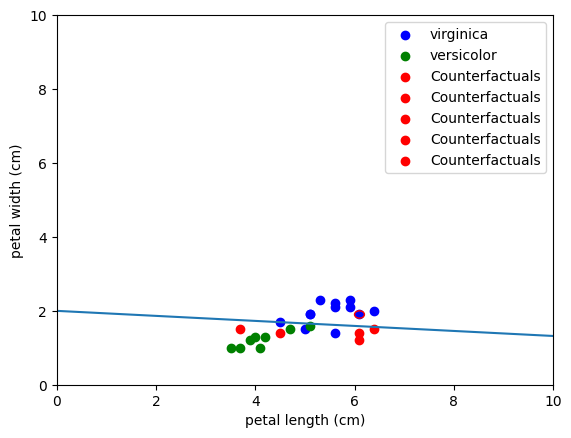

In [58]:
coefficients = model.linear.weight.detach().numpy()
biases = model.linear.bias.detach().numpy()
decision_boundary = lambda x : (-biases)/coefficients[0][1] - x*coefficients[0][0]/coefficients[0][1]

x = np.linspace(0, 10, 100)
y = decision_boundary(x)

features_test = test.numpy() if not isinstance(test, np.ndarray) else test
labels_test = labels_test.numpy() if not isinstance(labels_test, np.ndarray) else labels_test

# Plotting the decision boundary and the test set
feature_names = iris.feature_names[2:]
target_names = iris.target_names[1:][::-1]
plt.plot(x, y)
ix0 = (labels_test == 0).ravel()
ix1 = (labels_test == 1).ravel()
plt.scatter(features_test[ix0,0], features_test[ix0, 1], c = 'b', label = target_names[0])
plt.scatter(features_test[ix1,0], features_test[ix1, 1], c = 'g', label = target_names[1])
point_explained = features_test[i_explained,:]
circle = plt.Circle(point_explained, 0.1, color='r', fill=False)
plt.gca().add_patch(circle)



cfs_df = e1.cf_examples_list[0].final_cfs_df
print(cfs_df)
cfs_array = cfs_df.drop('label',axis=1).iloc[:].values.astype(float)
print(cfs_array)
print(cfs_array[0,:])
for i in range(cfs_array.shape[0]):
    plt.scatter(cfs_array[i,0], cfs_array[i,1], c = 'r', label = 'Counterfactuals')

plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()
